<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/Resnet_Thesis_Final_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers

In [ ]:
# Adding TF Cifar10 Data ..
from keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

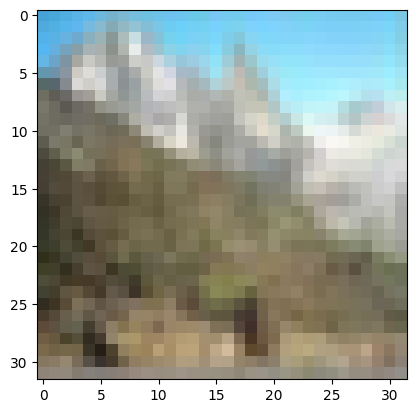

In [ ]:
# Drawing sample . 
plt.imshow(X_train[42])

In [ ]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [ ]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.res_5_1 = ResnetBlock(1024, down_sample=True)
        self.res_5_2 = ResnetBlock(1024)
        self.res_6_1 = ResnetBlock(2048, down_sample=True)
        self.res_6_2 = ResnetBlock(2048)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2, self.res_5_1, self.res_5_2, self.res_6_1, self.res_6_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_30 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_12 (ResnetBloc  multiple                 74368     
 k)                                                              
                                                                 
 resnet_block_13 (ResnetBloc  multiple                 74368     
 k)                                                    

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

Epoch 1/50
157/156 [==============================] - ETA: 0s - loss: 4.1896 - accuracy: 0.1008

156/156 [==============================] - 90s 442ms/step - loss: 4.1896 - accuracy: 0.1008 - val_loss: 7.1527 - val_accuracy: 0.0441
Epoch 2/50
157/156 [==============================] - ETA: 0s - loss: 3.7289 - accuracy: 0.1606

156/156 [==============================] - 68s 432ms/step - loss: 3.7289 - accuracy: 0.1606 - val_loss: 44.6824 - val_accuracy: 0.0178
Epoch 3/50
157/156 [==============================] - ETA: 0s - loss: 3.6303 - accuracy: 0.1875

156/156 [==============================] - 67s 431ms/step - loss: 3.6303 - accuracy: 0.1875 - val_loss: 6.6302 - val_accuracy: 0.0175
Epoch 4/50
157/156 [==============================] - ETA: 0s - loss: 3.5967 - accuracy: 0.1856

156/156 [==============================] - 68s 435ms/step - loss: 3.5967 - accuracy: 0.1856 - val_loss: 12.6278 - val_accuracy: 0.0303
Epoch 5/50
157/156 [==============================] - ETA: 0s - loss: 3.1192 - accuracy: 0.2488

156/156 [==============================] - 68s 433ms/step - loss: 3.1192 - accuracy: 0.2488 - val_loss: 3.3038 - val_accuracy: 0.2026
Epoch 6/50
157/156 [==============================] - ETA: 0s - loss: 2.8851 - accuracy: 0.2826

156/156 [==============================] - 67s 431ms/step - loss: 2.8851 - accuracy: 0.2826 - val_loss: 3.0951 - val_accuracy: 0.2623
Epoch 7/50
157/156 [==============================] - ETA: 0s - loss: 2.8630 - accuracy: 0.2964

156/156 [==============================] - 68s 432ms/step - loss: 2.8630 - accuracy: 0.2964 - val_loss: 4.6790 - val_accuracy: 0.1852
Epoch 8/50
157/156 [==============================] - ETA: 0s - loss: 2.8050 - accuracy: 0.3021

156/156 [==============================] - 68s 435ms/step - loss: 2.8050 - accuracy: 0.3021 - val_loss: 1207.8103 - val_accuracy: 0.0099
Epoch 9/50
157/156 [==============================] - ETA: 0s - loss: 2.7580 - accuracy: 0.3102

156/156 [==============================] - 59s 376ms/step - loss: 2.7580 - accuracy: 0.3102 - val_loss: 3.1789 - val_accuracy: 0.2812
Epoch 10/50
157/156 [==============================] - ETA: 0s - loss: 2.5061 - accuracy: 0.3600

156/156 [==============================] - 68s 433ms/step - loss: 2.5061 - accuracy: 0.3600 - val_loss: 2.4967 - val_accuracy: 0.3455
Epoch 11/50
157/156 [==============================] - ETA: 0s - loss: 2.3601 - accuracy: 0.3909

156/156 [==============================] - 59s 374ms/step - loss: 2.3601 - accuracy: 0.3909 - val_loss: 2.4417 - val_accuracy: 0.3655
Epoch 12/50
157/156 [==============================] - ETA: 0s - loss: 2.2337 - accuracy: 0.4150

156/156 [==============================] - 68s 434ms/step - loss: 2.2337 - accuracy: 0.4150 - val_loss: 2.2722 - val_accuracy: 0.4145
Epoch 13/50
157/156 [==============================] - ETA: 0s - loss: 2.0979 - accuracy: 0.4455

156/156 [==============================] - 59s 377ms/step - loss: 2.0979 - accuracy: 0.4455 - val_loss: 2.0310 - val_accuracy: 0.4502
Epoch 14/50
157/156 [==============================] - ETA: 0s - loss: 1.9859 - accuracy: 0.4677

156/156 [==============================] - 68s 433ms/step - loss: 1.9859 - accuracy: 0.4677 - val_loss: 2.1327 - val_accuracy: 0.4541
Epoch 15/50
157/156 [==============================] - ETA: 0s - loss: 1.8706 - accuracy: 0.4927

156/156 [==============================] - 68s 433ms/step - loss: 1.8706 - accuracy: 0.4927 - val_loss: 2.4492 - val_accuracy: 0.4012
Epoch 16/50
157/156 [==============================] - ETA: 0s - loss: 1.7674 - accuracy: 0.5167

156/156 [==============================] - 68s 436ms/step - loss: 1.7674 - accuracy: 0.5167 - val_loss: 1.9424 - val_accuracy: 0.4681
Epoch 17/50
157/156 [==============================] - ETA: 0s - loss: 1.6470 - accuracy: 0.5458

156/156 [==============================] - 58s 372ms/step - loss: 1.6470 - accuracy: 0.5458 - val_loss: 1.7377 - val_accuracy: 0.5586
Epoch 18/50
157/156 [==============================] - ETA: 0s - loss: 1.5409 - accuracy: 0.5768

156/156 [==============================] - 67s 429ms/step - loss: 1.5409 - accuracy: 0.5768 - val_loss: 134.6816 - val_accuracy: 0.1843
Epoch 19/50
157/156 [==============================] - ETA: 0s - loss: 1.4932 - accuracy: 0.5809

156/156 [==============================] - 59s 378ms/step - loss: 1.4932 - accuracy: 0.5809 - val_loss: 1.9661 - val_accuracy: 0.4793
Epoch 20/50
157/156 [==============================] - ETA: 0s - loss: 1.2792 - accuracy: 0.6366

156/156 [==============================] - 67s 431ms/step - loss: 1.2792 - accuracy: 0.6366 - val_loss: 1.0316 - val_accuracy: 0.7157
Epoch 21/50
157/156 [==============================] - ETA: 0s - loss: 1.1866 - accuracy: 0.6642

156/156 [==============================] - 58s 369ms/step - loss: 1.1866 - accuracy: 0.6642 - val_loss: 5.1321 - val_accuracy: 0.1695
Epoch 22/50
157/156 [==============================] - ETA: 0s - loss: 1.1682 - accuracy: 0.6658

156/156 [==============================] - 67s 432ms/step - loss: 1.1682 - accuracy: 0.6658 - val_loss: 2.0027 - val_accuracy: 0.5277
Epoch 23/50
157/156 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.7189

156/156 [==============================] - 68s 432ms/step - loss: 0.9669 - accuracy: 0.7189 - val_loss: 1.2626 - val_accuracy: 0.7199
Epoch 24/50
157/156 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.7673

156/156 [==============================] - 68s 432ms/step - loss: 0.7921 - accuracy: 0.7673 - val_loss: 1.5095 - val_accuracy: 0.7316
Epoch 25/50
157/156 [==============================] - ETA: 0s - loss: 0.8548 - accuracy: 0.7545

156/156 [==============================] - 58s 372ms/step - loss: 0.8548 - accuracy: 0.7545 - val_loss: 64.9620 - val_accuracy: 0.2973
Epoch 26/50
157/156 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.7945

156/156 [==============================] - 68s 436ms/step - loss: 0.7219 - accuracy: 0.7945 - val_loss: 0.6630 - val_accuracy: 0.8066
Epoch 27/50
157/156 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.8453

156/156 [==============================] - 68s 434ms/step - loss: 0.5385 - accuracy: 0.8453 - val_loss: 0.5579 - val_accuracy: 0.8329
Epoch 28/50
157/156 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.8666

156/156 [==============================] - 68s 433ms/step - loss: 0.4770 - accuracy: 0.8666 - val_loss: 0.4162 - val_accuracy: 0.8710
Epoch 29/50
157/156 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8750

156/156 [==============================] - 68s 433ms/step - loss: 0.4353 - accuracy: 0.8750 - val_loss: 0.9719 - val_accuracy: 0.7235
Epoch 30/50
157/156 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8814

156/156 [==============================] - 68s 435ms/step - loss: 0.4139 - accuracy: 0.8814 - val_loss: 0.6325 - val_accuracy: 0.8284
Epoch 31/50
157/156 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8997

156/156 [==============================] - 68s 435ms/step - loss: 0.3593 - accuracy: 0.8997 - val_loss: 0.3675 - val_accuracy: 0.9123
Epoch 32/50
157/156 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.7787

156/156 [==============================] - 59s 375ms/step - loss: 0.9216 - accuracy: 0.7787 - val_loss: 34.4223 - val_accuracy: 0.0333
Epoch 33/50
157/156 [==============================] - ETA: 0s - loss: 1.2364 - accuracy: 0.6485

156/156 [==============================] - 67s 430ms/step - loss: 1.2364 - accuracy: 0.6485 - val_loss: 1.5086 - val_accuracy: 0.5759
Epoch 34/50
157/156 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.8315

156/156 [==============================] - 68s 435ms/step - loss: 0.5734 - accuracy: 0.8315 - val_loss: 1.5854 - val_accuracy: 0.6686
Epoch 35/50
157/156 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8849

156/156 [==============================] - 59s 376ms/step - loss: 0.4161 - accuracy: 0.8849 - val_loss: 1.3564 - val_accuracy: 0.7721
Epoch 36/50
157/156 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8982

156/156 [==============================] - 68s 434ms/step - loss: 0.3743 - accuracy: 0.8982 - val_loss: 0.3868 - val_accuracy: 0.8934
Epoch 37/50
157/156 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.9267

156/156 [==============================] - 58s 374ms/step - loss: 0.2777 - accuracy: 0.9267 - val_loss: 0.2363 - val_accuracy: 0.9406
Epoch 38/50
157/156 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9244

156/156 [==============================] - 59s 375ms/step - loss: 0.2921 - accuracy: 0.9244 - val_loss: 0.2290 - val_accuracy: 0.9344
Epoch 39/50
157/156 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9308

156/156 [==============================] - 68s 434ms/step - loss: 0.2590 - accuracy: 0.9308 - val_loss: 0.1906 - val_accuracy: 0.9420
Epoch 40/50
157/156 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9428

156/156 [==============================] - 68s 435ms/step - loss: 0.2157 - accuracy: 0.9428 - val_loss: 0.3510 - val_accuracy: 0.9198
Epoch 41/50
157/156 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9398

156/156 [==============================] - 59s 375ms/step - loss: 0.2247 - accuracy: 0.9398 - val_loss: 0.1647 - val_accuracy: 0.9573
Epoch 42/50
157/156 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9459

156/156 [==============================] - 59s 375ms/step - loss: 0.1971 - accuracy: 0.9459 - val_loss: 0.2819 - val_accuracy: 0.9521
Epoch 43/50
157/156 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9494

156/156 [==============================] - 59s 378ms/step - loss: 0.1844 - accuracy: 0.9494 - val_loss: 0.2098 - val_accuracy: 0.9395
Epoch 44/50
157/156 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9470

156/156 [==============================] - 68s 433ms/step - loss: 0.2024 - accuracy: 0.9470 - val_loss: 0.6188 - val_accuracy: 0.9505
Epoch 45/50
157/156 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9321

156/156 [==============================] - 58s 373ms/step - loss: 0.2565 - accuracy: 0.9321 - val_loss: 0.6149 - val_accuracy: 0.9156
Epoch 46/50
157/156 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.9464

156/156 [==============================] - 68s 436ms/step - loss: 0.2132 - accuracy: 0.9464 - val_loss: 0.3871 - val_accuracy: 0.9198
Epoch 47/50
157/156 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.8714

156/156 [==============================] - 68s 434ms/step - loss: 0.4833 - accuracy: 0.8714 - val_loss: 1.5691 - val_accuracy: 0.6037
Epoch 48/50
157/156 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9144

156/156 [==============================] - 68s 433ms/step - loss: 0.3192 - accuracy: 0.9144 - val_loss: 0.5739 - val_accuracy: 0.9120
Epoch 49/50
157/156 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9478

156/156 [==============================] - 58s 373ms/step - loss: 0.2049 - accuracy: 0.9478 - val_loss: 0.1390 - val_accuracy: 0.9583
Epoch 50/50
157/156 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9564

156/156 [==============================] - 59s 378ms/step - loss: 0.1806 - accuracy: 0.9564 - val_loss: 0.4175 - val_accuracy: 0.9068


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


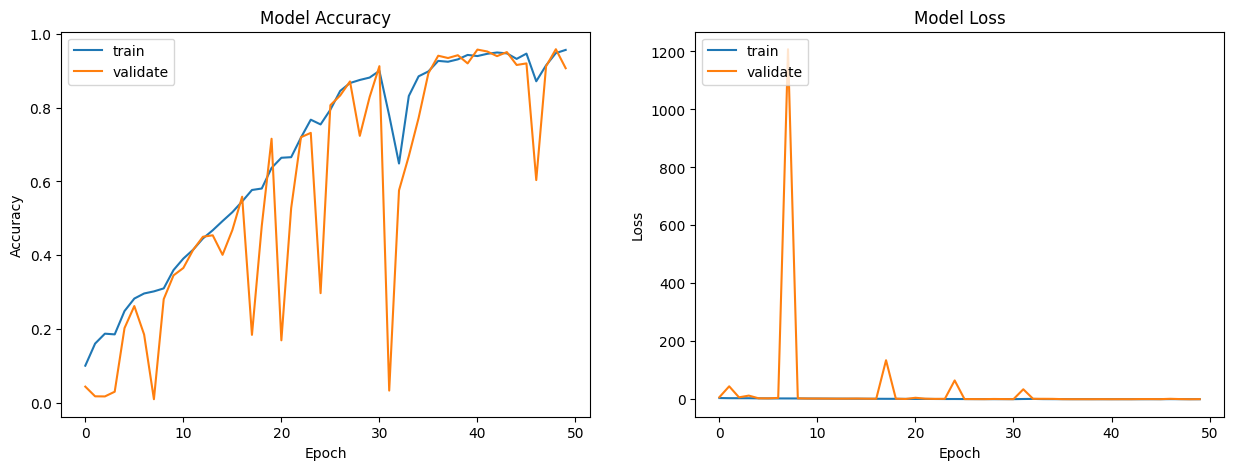

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [ ]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 61s 49ms/step - loss: 0.4175 - accuracy: 0.9068
Model Loss is 0.41752129793167114
Model Accuracy is 0.9068250060081482
